In [19]:
import sys, glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gs
from itertools import permutations, combinations
import scipy
donors = [f'TBd{k}' for k in range(1,7)]
TARGET_LOCUS='IGH'

######################## PATH CONFIG ################################

full_df_loc = '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'
ASC_subtype_df_loc = '../../data/vdj/ASC_subtypes.tab'
sample_relationships_df_loc = '../../snakemake_workflow/samplesheets/sample_relationships.tsv'
FIGURE_OUTDIR = '../figures/paper figures'
SI_FIGURE_OUTDIR = '../figures/si figures'
######################## ############ ################################
from tb_colormaps import *
plt.style.use('./bursa.mplstyle')

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
%load_ext autoreload
%autoreload 2
np.random.seed(5)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and prepare data for analysis

In [20]:
sample_relationships = pd.read_table(sample_relationships_df_loc)
sample_relationships.encapsulation_sibling_sample = sample_relationships.encapsulation_sibling_sample.fillna("")
sample_relationships['emulsion'] = sample_relationships.apply(lambda x: ";".join(sorted([x.sample_uid_vdj, x.encapsulation_sibling_sample])), axis=1)
sample_relationships= sample_relationships.set_index('sample_uid_vdj')
sample_relationships['tissue'] = sample_relationships.donor_tissue.map(lambda x: x.split("_")[-1])

df = pd.read_table(full_df_loc, low_memory=False, usecols = ['sample_uid_vdj',
                                                             'vdj_sequence',
                                                             'v_identity',
                                                             'v_mismatch',
                                                             'lineage_id',
                                                             'donor', 
                                                             'tissue'])
df = df[(df.vdj_sequence.notna()) & (df.lineage_id.notna())]
df['emulsion'] = df.sample_uid_vdj.map(sample_relationships['emulsion'])
df = df.drop_duplicates(ignore_index=True)

In [21]:
MIN_VDJS = 5000

n_vdjs = df.groupby(['emulsion'])['vdj_sequence'].nunique()
print(n_vdjs.sort_values()[n_vdjs.sort_values() < MIN_VDJS])
print(n_vdjs.min(), n_vdjs.max())
sufficiently_large_samples = n_vdjs[n_vdjs > MIN_VDJS].index
sample_relationships = sample_relationships[sample_relationships.emulsion.isin(sufficiently_large_samples)]
print(df.shape)
df = df[df.emulsion.isin(sufficiently_large_samples)]
print(df.shape)

df = df.groupby('emulsion').sample(n=MIN_VDJS, replace=False)
print(df.shape)


emulsion
TBd5_frozen_PB_HTa;TBd5_frozen_PB_HTb             139
TBd5_frozen_PBover_HTa;TBd5_frozen_PBover_HTb     445
;TBd3_fresh_BM_a                                 2803
;TBd3_fresh_BM_b                                 3008
TBd4_frozen_BM_HTa;TBd4_frozen_BM_HTb            3159
;TBd3_fresh_PB_b                                 3170
;TBd3_fresh_PB_a                                 3450
TBd1_frozen_BM_HTa;TBd1_frozen_BM_HTb            3630
TBd2_frozen_BM_HTa;TBd2_frozen_BM_HTb            3663
TBd5_frozen_BM_HTa;TBd5_frozen_BM_HTb            4359
;TBd6_fresh_BM                                   4839
Name: vdj_sequence, dtype: int64
139 39632
(734060, 8)
(701255, 8)
(210000, 8)


### Construct lineage unique VDJ count dataframe 

In [22]:

def count_and_pivot(data_frame, index_col, column_col, fill_value=None, norm=False):
    new_df = data_frame.groupby([index_col, column_col])['vdj_sequence'].nunique().reset_index()
    if fill_value is None:
        new_df = new_df.pivot(index=index_col, columns = column_col, values='vdj_sequence')
    else:
        new_df = new_df.pivot(index=index_col, columns = column_col, values='vdj_sequence').fillna(fill_value).astype('int64')
    if norm:
        new_df = new_df/new_df.sum(axis=0)
    return new_df

cell_counts_all = count_and_pivot(df, 'lineage_id', 'emulsion', norm=True)
import warnings
warnings.filterwarnings(action='ignore')
new_cols_all = {}
log_base = 2.5
for col in df.emulsion[df.emulsion.notna()].unique():
    new_cols_all.update({f'{col}_binned':log_base**round(np.log10(cell_counts_all[col])/np.log10(log_base))})
    new_cols_all.update({f'{col}_binarized': cell_counts_all[col].notna()})
new_cols_all = pd.DataFrame(new_cols_all)
cell_counts_all = cell_counts_all.join(new_cols_all)

### Set up data structures for sharing analysis

In [23]:
tissue_list = ['PB','BM','SP','LN']
tissue_indices = {'PB':0, 'BM':1, 'SP':2, 'LN':3}

tissue_dict = sample_relationships[['emulsion','tissue']].drop_duplicates(ignore_index=True).set_index('emulsion')['tissue'].to_dict()

donor_tissue_list = sample_relationships.reset_index().groupby('donor_tissue')['emulsion'].agg(list)
donor_tissue_availability = sample_relationships.groupby('donor')['donor_tissue'].agg(list)


sibling_pairs = sample_relationships.encapsulation_sibling_sample[sample_relationships.encapsulation_sibling_sample.notna()].to_dict()
sample_replicates = sample_relationships.reset_index().groupby(['cell_suspension'])['emulsion'].agg(list).to_dict()
tissue_replicates = sample_relationships.reset_index().groupby(['donor_tissue'])['emulsion'].agg(list).to_dict()
sample_replicate_dict = {}
for cell_suspension, samples in sample_replicates.items():
    for x in samples:
        exclude_self_and_sib = [x, sibling_pairs.get(x)]
        sample_replicate_dict.update({x:[y for y in samples if not (y in exclude_self_and_sib)]})
        
tissue_replicate_dict = {}
for tissue, samples in tissue_replicates.items():
    for x in samples:
        exclude=[x, sibling_pairs.get(x)] + sample_replicate_dict.get(x)
        if len(exclude) < len(samples):
            tissue_replicate_dict.update({x:[y for y in samples if not (y in exclude)]})


In [24]:
norm_dict = {x:sample_replicate_dict.get(x,[]) + tissue_replicate_dict.get(x,[]) 
             for x in (list(sample_replicate_dict.keys()) + list(tissue_replicate_dict.keys()))}
test_dict = {(t,dt):{} for t, dt in permutations(tissue_list,2)}
for t, dt in test_dict.keys():
        relevant_donors = [d for d in donors if (f'{d}_{t}' in donor_tissue_availability[d]) 
                                            and (f'{d}_{dt}' in donor_tissue_availability[d])]
        for d in relevant_donors:
            test_dict[(t,dt)].update({d:
                                      {x:[y 
                                          for y in donor_tissue_list[f'{d}_{dt}']
                                         ] 
                                      for x in donor_tissue_list[f'{d}_{t}']
                                      } 
                                     })
pair_test_dict = {(t1, t2, dt):{} for t1, t2, dt in permutations(tissue_list,3)
                 if tissue_indices[t1] < tissue_indices[t2]}
pair_norm_dict = {}

for t1, t2, dt in pair_test_dict.keys():

        relevant_donors = [d for d in donors if ((f'{d}_{t1}' in donor_tissue_availability[d])
                                            and (f'{d}_{t2}' in donor_tissue_availability[d])) 
                                            and (f'{d}_{dt}' in donor_tissue_availability[d])]
        for d in relevant_donors:
            t1_samples = [x for x in donor_tissue_list[f'{d}_{t1}']]
            t2_samples = [x for x in donor_tissue_list[f'{d}_{t2}']]
            dt_samples = [x for x in donor_tissue_list[f'{d}_{dt}']]
            
            pair_test_dict[(t1,t2,dt)].update({d:{(x,y):[z for z in dt_samples]
                                                for x in t1_samples
                                                for y in t2_samples}})
            pair_norm_dict.update({(x,y):norm_dict[x] + norm_dict[y]
                                            for x in t1_samples
                                            for y in t2_samples
                                           })
            
triplet_test_dict = {(t1, t2, t3, dt):{} for t1, t2, t3, dt in permutations(tissue_list,4)
                 if (tissue_indices[t1] < tissue_indices[t2])
                 and (tissue_indices[t2] < tissue_indices[t3])}
triplet_norm_dict = {}

for t1, t2, t3, dt in triplet_test_dict.keys():

        relevant_donors = [d for d in donors if (((f'{d}_{t1}' in donor_tissue_availability[d])
                                              and (f'{d}_{t2}' in donor_tissue_availability[d]))
                                             and (f'{d}_{t3}' in donor_tissue_availability[d]))
                                             and (f'{d}_{dt}' in donor_tissue_availability[d])]
        for d in relevant_donors:
            t1_samples = [x for x in donor_tissue_list[f'{d}_{t1}']]
            t2_samples = [x for x in donor_tissue_list[f'{d}_{t2}']]
            t3_samples = [x for x in donor_tissue_list[f'{d}_{t3}']]
            dt_samples = [x for x in donor_tissue_list[f'{d}_{dt}']]
            
            triplet_test_dict[(t1,t2,t3,dt)].update({d:{(x,y,z):[z for z in dt_samples]
                                                for x in t1_samples
                                                for y in t2_samples
                                                for z in t3_samples}})
            triplet_norm_dict.update({(x,y,z):norm_dict[x] + norm_dict[y] + norm_dict[z]
                                            for x in t1_samples
                                            for y in t2_samples
                                            for z in t3_samples
                                           })

### Define function to calculate relative sharing amounts

In [25]:
def calculate_discovery_prob_unscaled_two_tissue(data_frame, test_dict, binarized=True):
    all_freqs = []

    for k in test_dict.keys():
        test_cols = [f'{x}_binarized' for x in test_dict[k]]
        if binarized:
            gb = 'binarized'
        else:
            gb='binned'
        present = data_frame[f'{k}_{gb}']
        freqs = data_frame.groupby(present)[test_cols].mean()
        freqs[f'{k}_test_mean'] = freqs[test_cols].mean(axis=1)
        all_freqs.append(freqs[f'{k}_test_mean'])
    all_freqs = pd.concat(all_freqs, axis=1)
    
    all_freqs['mean_ratio'] = all_freqs[[x for x in all_freqs.columns if x.endswith('test_mean')]].mean(axis=1)
    all_freqs['std_ratio'] = all_freqs[[x for x in all_freqs.columns if x.endswith('test_mean')]].std(axis=1)
    ns = all_freqs[[x for x in all_freqs.columns if x.endswith('ratio')]].notna().sum(axis=1)
    all_freqs['std_err'] = all_freqs['std_ratio']/np.sqrt(np.maximum(ns-1,1))
    
    if binarized:
        all_freqs = all_freqs.T[True].T

    return all_freqs

def calculate_discovery_prob_unscaled_three_tissue(data_frame, test_dict, binarized=True):
    all_freqs = []

    for s1,s2 in test_dict.keys():
        k = "{}_{}".format(s1,s2)
        if binarized:
            gb = 'binarized'
        else:
            gb='binned'
        test_cols = [f'{x}_binarized' for x in test_dict[(s1,s2)]]
        
        present = data_frame[[f'{s1}_{gb}',f'{s2}_{gb}']].sum(axis=1) == 2
        freqs = data_frame.groupby(present)[test_cols].mean()
        freqs[f'{k}_test_mean'] = freqs[test_cols].mean(axis=1)
        all_freqs.append(freqs[f'{k}_test_mean'])
    all_freqs = pd.concat(all_freqs, axis=1)
    
    all_freqs['mean_ratio'] = all_freqs[[x for x in all_freqs.columns if x.endswith('test_mean')]].mean(axis=1)
    all_freqs['std_ratio'] = all_freqs[[x for x in all_freqs.columns if x.endswith('test_mean')]].std(axis=1)
    ns = all_freqs[[x for x in all_freqs.columns if x.endswith('ratio')]].notna().sum(axis=1)
    all_freqs['std_err'] = all_freqs['std_ratio']/np.sqrt(np.maximum(ns-1,1))
    if binarized:
        all_freqs = all_freqs.T[True].T

    return all_freqs

def calculate_discovery_prob_unscaled_four_tissue(data_frame, test_dict, binarized=True):
    all_freqs = []

    for s1,s2,s3 in test_dict.keys():
        k = "{}_{}".format(s1,s2)

        test_cols = [f'{x}_binarized' for x in test_dict[(s1,s2,s3)]]
        if binarized:
            gb = 'binarized'
        else:
            gb='binned'
        present = data_frame[[f'{s1}_{gb}',
                                       f'{s2}_{gb}',
                                       f'{s3}_{gb}']].sum(axis=1) == 3
        freqs = data_frame.groupby(present)[test_cols].mean()
        freqs[f'{k}_test_mean'] = freqs[test_cols].mean(axis=1)
        all_freqs.append(freqs[f'{k}_test_mean'])
    all_freqs = pd.concat(all_freqs, axis=1)
    
    all_freqs['mean_ratio'] = all_freqs[[x for x in all_freqs.columns if x.endswith('test_mean')]].mean(axis=1)
    all_freqs['std_ratio'] = all_freqs[[x for x in all_freqs.columns if x.endswith('test_mean')]].std(axis=1)
    ns = all_freqs[[x for x in all_freqs.columns if x.endswith('ratio')]].notna().sum(axis=1)
    all_freqs['std_err'] = all_freqs['std_ratio']/np.sqrt(np.maximum(ns-1,1))
    if binarized:
        all_freqs = all_freqs.T[True].T

    return all_freqs

In [26]:
def calculate_discovery_prob_scaled_two_tissue(data_frame, 
                                               norm_dict, 
                                               test_dict, 
                                               binarized=True):
    all_freqs = []
    EPS=10**-3
    for k in test_dict.keys():
        norm_cols = [f'{x}_binarized' for x in norm_dict[k]]
        test_cols = [f'{x}_binarized' for x in test_dict[k]]
        all_cols = norm_cols + test_cols
        if binarized:
            gb_col = 'binarized'
        else:
            gb_col = 'binned'  
        freqs = data_frame.groupby(f'{k}_{gb_col}')[all_cols].sum()
        freqs[f'{k}_norm_mean'] = freqs[norm_cols].mean(axis=1)
        freqs[f'{k}_test_mean'] = freqs[test_cols].mean(axis=1)
        freqs[f'{k}_ratio'] = (freqs[f'{k}_test_mean']+EPS)/(freqs[f'{k}_norm_mean']+EPS)
        all_freqs.append(freqs[[f'{k}_norm_mean', f'{k}_test_mean', f'{k}_ratio']])
    all_freqs = pd.concat(all_freqs, axis=1)
    
    all_freqs['mean_ratio'] = all_freqs[[x for x in all_freqs.columns if x.endswith('ratio')]].mean(axis=1)
    all_freqs['std_ratio'] = all_freqs[[x for x in all_freqs.columns if x.endswith('ratio')]].std(axis=1)
    ns = all_freqs[[x for x in all_freqs.columns if x.endswith('ratio')]].notna().sum(axis=1)
    all_freqs['std_err'] = all_freqs['std_ratio']/np.sqrt(np.maximum(ns-1,1))
    
    if binarized:
        all_freqs = all_freqs.T[True].T

    return all_freqs

def calculate_discovery_prob_scaled_three_tissue(data_frame, 
                                                 norm_dict, 
                                                 test_dict, 
                                                 binarized=True):
    all_freqs = []
    EPS=10**-3
    for s1,s2 in test_dict.keys():
        norm_cols = [f'{x}_binarized' for x in norm_dict[(s1,s2)]]
        test_cols = [f'{x}_binarized' for x in test_dict[(s1,s2)]]
        all_cols = norm_cols + test_cols
        
        if binarized:
            gb_col = 'binarized'
        else:
            gb_col = 'binned'
  
        present_in_s1_s2 = data_frame[[f'{s1}_{gb_col}',f'{s2}_{gb_col}']].sum(axis=1) == 2
        freqs = data_frame.groupby(present_in_s1_s2)[all_cols].sum()
        freqs[f'{s1}_{s2}_norm_mean'] = freqs[norm_cols].mean(axis=1)
        freqs[f'{s1}_{s2}_test_mean'] = freqs[test_cols].mean(axis=1)
        freqs[f'{s1}_{s2}_ratio'] = (freqs[f'{s1}_{s2}_test_mean']+EPS)/(
                                     freqs[f'{s1}_{s2}_norm_mean']+EPS)
        all_freqs.append(freqs[[f'{s1}_{s2}_norm_mean', 
                                f'{s1}_{s2}_test_mean', 
                                f'{s1}_{s2}_ratio']])
    all_freqs = pd.concat(all_freqs, axis=1)
    
    all_freqs['mean_ratio'] = all_freqs[[x for x in all_freqs.columns if x.endswith('ratio')]].mean(axis=1)
    all_freqs['std_ratio'] = all_freqs[[x for x in all_freqs.columns if x.endswith('ratio')]].std(axis=1)
    ns = all_freqs[[x for x in all_freqs.columns if x.endswith('ratio')]].notna().sum(axis=1)
    all_freqs['std_err'] = all_freqs['std_ratio']/np.sqrt(np.maximum(ns-1,1))
    
    if binarized:
        all_freqs = all_freqs.T[True].T

    return all_freqs

def calculate_discovery_prob_scaled_four_tissue(data_frame, 
                                                norm_dict, 
                                                test_dict,
                                                binarized=True):
    all_freqs = []
    EPS=10**-3
    for s1,s2,s3 in test_dict.keys():
        norm_cols = [f'{x}_binarized' for x in norm_dict[(s1,s2,s3)]]
        test_cols = [f'{x}_binarized' for x in test_dict[(s1,s2,s3)]]
        all_cols = norm_cols + test_cols
        
        if binarized:
            gb_col = 'binarized'
        else:
            gb_col = 'binned'
        
        present_in_s1_s2_s3 = data_frame[[f'{s1}_{gb_col}',
                                       f'{s2}_{gb_col}',
                                       f'{s3}_{gb_col}']].sum(axis=1) == 3
        freqs = data_frame.groupby(present_in_s1_s2_s3)[all_cols].sum()
        freqs[f'{s1}_{s2}_{s3}_norm_mean'] = freqs[norm_cols].mean(axis=1)
        freqs[f'{s1}_{s2}_{s3}_test_mean'] = freqs[test_cols].mean(axis=1)
        freqs[f'{s1}_{s2}_{s3}_ratio'] = (freqs[f'{s1}_{s2}_{s3}_test_mean']+EPS)/(
                                     freqs[f'{s1}_{s2}_{s3}_norm_mean']+EPS)
        all_freqs.append(freqs[[f'{s1}_{s2}_{s3}_norm_mean', 
                                f'{s1}_{s2}_{s3}_test_mean', 
                                f'{s1}_{s2}_{s3}_ratio']])
    all_freqs = pd.concat(all_freqs, axis=1)
    
    all_freqs['mean_ratio'] = all_freqs[[x for x in all_freqs.columns if x.endswith('ratio')]].mean(axis=1)
    all_freqs['std_ratio'] = all_freqs[[x for x in all_freqs.columns if x.endswith('ratio')]].std(axis=1)
    ns = all_freqs[[x for x in all_freqs.columns if x.endswith('ratio')]].notna().sum(axis=1)
    all_freqs['std_err'] = all_freqs['std_ratio']/np.sqrt(np.maximum(ns-1,1))
    
    if binarized:
        all_freqs = all_freqs.T[True].T

    return all_freqs


### Calculate lineage-size dependent sharing statistics

In [27]:
tissue_list = ['PB', 'BM', 'SP', 'LN']
tissue_pairs = list(combinations(tissue_list,2))
tissue_triplets = list(combinations(tissue_list,3))

dfs = []
for t1, t2 in test_dict.keys():
    for d, relevant_test_dict in test_dict[(t1,t2)].items():
        probs = calculate_discovery_prob_scaled_two_tissue(cell_counts_all, 
                                                           norm_dict, 
                                                           relevant_test_dict, 
                                                           binarized=False)
        if probs.std_err.notna().sum() > 0:
            probs = probs.reset_index().rename(columns={'index':'n'})
            update_stats = { 'n':probs['n'].astype(float),
                             'donor':d, 
                             'ascertained_in':f'{t1}',
                             'discovery_tissue':t2,
                             'mean':probs['mean_ratio'],
                             'std_err':probs['std_err'],
                             'n_ascertainment':1}
            for k,v in update_stats.items():
                probs[k] = v
            dfs.append(probs[[k for k in update_stats.keys()]])
singlet_prob_df = pd.concat(dfs)
dfs=[]
for t1, t2, t3 in pair_test_dict.keys():
    for d, relevant_test_dict in pair_test_dict[(t1,t2,t3)].items():
        probs = calculate_discovery_prob_scaled_three_tissue(cell_counts_all, 
                                                             pair_norm_dict, 
                                                             relevant_test_dict,
                                                             binarized=False)
        if probs.std_err.notna().sum() > 0:
            probs = probs.reset_index().rename(columns={'index':'n'})
            update_stats = { 'n':probs['n'].astype(float),
                             'donor':d, 
                             'ascertained_in':f'{t1},{t2}',
                             'discovery_tissue':t3,
                             'mean':probs['mean_ratio'],
                             'std_err':probs['std_err'],
                             'n_ascertainment':2}
            for k,v in update_stats.items():
                probs[k] = v
            dfs.append(probs[[k for k in update_stats.keys()]])

pair_prob_df = pd.concat(dfs)

dfs = []
for t1, t2, t3, dt in triplet_test_dict.keys():
    for d, relevant_test_dict in triplet_test_dict[(t1,t2,t3,dt)].items():
        probs = calculate_discovery_prob_scaled_four_tissue(cell_counts_all, 
                                                             triplet_norm_dict, 
                                                             relevant_test_dict,
                                                             binarized=False)
        
        if probs.mean_ratio.notna().sum() > 0:
            probs = probs.reset_index().rename(columns={'index':'n'})
            update_stats = { 'n':probs['n'].astype(int),
                             'donor':d, 
                             'ascertained_in':f'{t1},{t2},{t3}',
                             'discovery_tissue':dt,
                             'mean':probs['mean_ratio'],
                             'std_err':probs['std_err'],
                             'n_ascertainment':3}
            for k,v in update_stats.items():
                probs[k] = v
            dfs.append(probs[[k for k in update_stats.keys()]])

triplet_prob_df = pd.concat(dfs)
prob_df = pd.concat([singlet_prob_df, pair_prob_df, triplet_prob_df])
prob_df['n'] = prob_df['n'].astype(int)


### Plot sharing probability as a function of donor and frequency in discovery sample

In [28]:

from scipy.optimize import curve_fit
# probability of exit assuming constant per-sequence probability of exit
def f(x,a):
    return 1 - np.exp(-x/a)

TBd1
TBd2
TBd3
TBd4
TBd5
TBd6


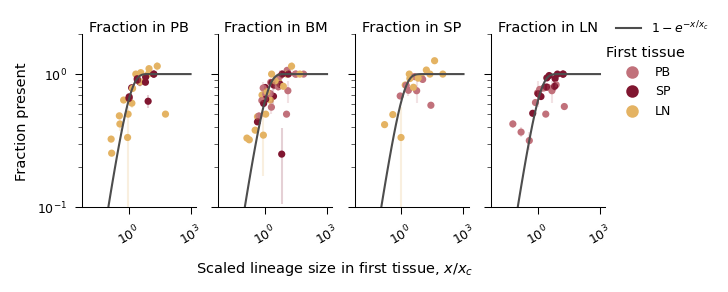

In [29]:

fitted_params = []
fig, ax = plt.subplots(1,4, figsize=(4.5,1.5), sharey=True, sharex=True)
ax = ax.flatten()
singlet_prob_df['p_missing'] = 1-singlet_prob_df['mean']
for d_it, donor in enumerate(donors):
    print(donor)
    n_tissues = len(set(donor_tissue_availability[donor]))
    donor_tissue_list = [t for t in tissue_list if f'{donor}_{t}' in donor_tissue_availability[donor]]
    for t_it, tissue in enumerate(tissue_list):
        i = t_it

        relevant_df = singlet_prob_df[(singlet_prob_df.discovery_tissue == tissue) 
                              & (singlet_prob_df.donor==donor)]
        if len(relevant_df) < 1:
            continue
        for at in relevant_df.ascertained_in.unique():
            tdf = relevant_df[relevant_df.ascertained_in == at]
            if tdf.shape[0]>0 and not (at == 'BM'):
 
                rez = curve_fit(f, tdf['n'], tdf['mean'])
                alpha = rez[0][0]
                fitted_params.append(pd.Series({'donor':donor,
                                                'ascertained':at,
                                                'discovered':tissue,
                                                'alpha':alpha}))

                # xs = np.logspace(-5,-2,50)
                # ax[i].plot(xs, 1-np.exp(-xs/alpha), color=tissue_colors[at])
                scaled_alpha = alpha
                ax[i].scatter(tdf['n']/scaled_alpha,
                        tdf['mean'],
                        color=tdf['ascertained_in'].map(tissue_colors),
                        s=6, 
                        clip_on=False)
                ax[i].errorbar(tdf['n']/scaled_alpha,
                        tdf['mean'],
                        tdf['std_err'],
                        alpha=0.2,
                        ecolor=tdf['ascertained_in'].map(tissue_colors),
                        fmt=' ',
                        clip_on=True)
            else:
                scaled_alpha=1
            ax[i].set_title(f'Fraction in {tissue}', fontsize=7, verticalalignment='top')

            
for i in range(4):          
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    xs = np.logspace(-2,3,50)
    ax[i].plot(xs, 1-np.exp(-xs), color='0.3', zorder=100)
    ax[i].set_ylim([0.1,2])

    ax[i].set_xlabel(f'')
    # ax[i].axhline(y=1, color='k', alpha=0.5, zorder=-1)
    ax[i].set_ylabel('')
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(30)
    r,g,b,a = mpl.colors.to_rgba(tissue_colors[tissue])
    bg_color = (r,g,b,0.5)

        # ax[i].set_facecolor(bg_color)
    sns.despine(fig)

ax[-1].plot([], [], color='0.3', zorder=100, label=r'$1 - e^{-x/x_c}$')
for tissue in ['PB','SP','LN']:
    ax[-2].scatter([],[], color=tissue_colors[tissue], label=tissue)
ax[0].set_ylabel('Fraction present')
ax[-1].legend(bbox_to_anchor=(1,1.15),loc='upper left', frameon=False)
ax[-2].legend(bbox_to_anchor=(3,1),loc='best', frameon=False, title='First tissue')

fig.supxlabel(f'Scaled lineage size in first tissue, $x/x_c$', fontsize=7, y=-0.2)

fitted_params = pd.DataFrame(fitted_params)
fig.savefig(f'{SI_FIGURE_OUTDIR}/collapse_by_tissue.pdf', bbox_inches='tight')

TBd1


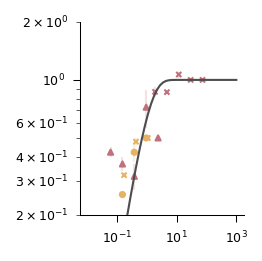

In [30]:

fitted_params = []


marker_dict = {'PB':'o','LN':'^','SP':'*', 'BM':'x'}
fig, ax = plt.subplots(1,1, figsize=(1.75,1.75), sharey=True, sharex=True)

singlet_prob_df['p_missing'] = 1-singlet_prob_df['mean']
for d_it, donor in enumerate(donors[:1]):
    print(donor)
    n_tissues = len(set(donor_tissue_availability[donor]))
    donor_tissue_list = [t for t in tissue_list if f'{donor}_{t}' in donor_tissue_availability[donor]]
    for t_it, tissue in enumerate(tissue_list):
        i = t_it

        relevant_df = singlet_prob_df[(singlet_prob_df.discovery_tissue == tissue) 
                              & (singlet_prob_df.donor==donor)]
        if len(relevant_df) < 1:
            continue
        for at in relevant_df.ascertained_in.unique():
            tdf = relevant_df[relevant_df.ascertained_in == at]
            if tdf.shape[0]>0 and not (at == 'BM'):
 
                rez = curve_fit(f, tdf['n'], tdf['mean'])
                alpha = rez[0][0]
                fitted_params.append(pd.Series({'donor':donor,
                                                'ascertained':at,
                                                'discovered':tissue,
                                                'alpha':alpha}))

                # xs = np.logspace(-5,-2,50)
                # ax[i].plot(xs, 1-np.exp(-xs/alpha), color=tissue_colors[at])
                scaled_alpha = alpha
                ax.scatter(tdf['n']/scaled_alpha,
                        tdf['mean'],
                        color=tdf['ascertained_in'].map(tissue_colors),
                        s=6, 
                        clip_on=False,
                        marker=marker_dict[tissue])
                
                ax.errorbar(tdf['n']/scaled_alpha,
                        tdf['mean'],
                        tdf['std_err'],
                        alpha=0.2,
                        ecolor=tdf['ascertained_in'].map(tissue_colors),
                        fmt=' ',
                        clip_on=True)
            else:
                scaled_alpha=1
            # ax.set_title(f'Probability\nalso in {tissue}', weight='bold', color=tissue_colors[tissue])

            
    ax.set_yscale('log')
    ax.set_xscale('log')
    xs = np.logspace(-2,3,50)
    ax.set_ylim([0.2,2])
    for tissue in ['PB','BM','SP','LN']:
        ax.plot([],[],lw=5, label=f'discovered in {tissue}', color=tissue_colors[tissue])
    for tissue in ['PB','BM','SP','LN']:
        ax.scatter([],[], marker=marker_dict[tissue], color='k', label=f'also detected in {tissue}', s=8)
ax.plot(xs, 1-np.exp(-xs), color='0.3', zorder=100, label=r'$1 - e^{-x/x_c}$')

ax.set_xlabel(f'')
# ax.axhline(y=1, color='k', alpha=0.5, zorder=-1)
ax.set_ylabel('')

r,g,b,a = mpl.colors.to_rgba(tissue_colors[tissue])
bg_color = (r,g,b,0.5)

# ax[i].set_facecolor(bg_color)
sns.despine(fig)
# ax.set_ylabel('Scaled probability of\ndetection in second tissue')

# ax.legend(bbox_to_anchor=(1,1),loc='best', frameon=False, ncols=2, handlelength=0.7)
# ax.set_xlabel(f'Scaled lineage size in discovery tissue, $x/x_c$', fontsize=7, y=-0.1)
fig.tight_layout()

fitted_params = pd.DataFrame(fitted_params)
fig.savefig(f'{FIGURE_OUTDIR}/EDFigure3/collapse_donor1.pdf', bbox_inches='tight')

TBd2
TBd3
TBd4
TBd5
TBd6


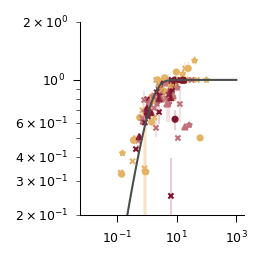

In [31]:

fitted_params = []


marker_dict = {'PB':'o','LN':'^','SP':'*', 'BM':'x'}
fig, ax = plt.subplots(1,1, figsize=(1.75,1.75), sharey=True, sharex=True)

singlet_prob_df['p_missing'] = 1-singlet_prob_df['mean']
for d_it, donor in enumerate(donors[1:]):
    print(donor)
    n_tissues = len(set(donor_tissue_availability[donor]))
    donor_tissue_list = [t for t in tissue_list if f'{donor}_{t}' in donor_tissue_availability[donor]]
    for t_it, tissue in enumerate(tissue_list):
        i = t_it

        relevant_df = singlet_prob_df[(singlet_prob_df.discovery_tissue == tissue) 
                              & (singlet_prob_df.donor==donor)]
        if len(relevant_df) < 1:
            continue
        for at in relevant_df.ascertained_in.unique():
            tdf = relevant_df[relevant_df.ascertained_in == at]
            if tdf.shape[0]>0 and not (at == 'BM'):
 
                rez = curve_fit(f, tdf['n'], tdf['mean'])
                alpha = rez[0][0]
                fitted_params.append(pd.Series({'donor':donor,
                                                'ascertained':at,
                                                'discovered':tissue,
                                                'alpha':alpha}))

                # xs = np.logspace(-5,-2,50)
                # ax[i].plot(xs, 1-np.exp(-xs/alpha), color=tissue_colors[at])
                scaled_alpha = alpha
                ax.scatter(tdf['n']/scaled_alpha,
                        tdf['mean'],
                        color=tdf['ascertained_in'].map(tissue_colors),
                        s=6, 
                        clip_on=False,
                        marker=marker_dict[tissue])
                
                ax.errorbar(tdf['n']/scaled_alpha,
                        tdf['mean'],
                        tdf['std_err'],
                        alpha=0.2,
                        ecolor=tdf['ascertained_in'].map(tissue_colors),
                        fmt=' ',
                        clip_on=True)
            else:
                scaled_alpha=1
            # ax.set_title(f'Probability\nalso in {tissue}', weight='bold', color=tissue_colors[tissue])

            
    ax.set_yscale('log')
    ax.set_xscale('log')
    xs = np.logspace(-2,3,50)
    ax.set_ylim([0.2,2])
    for tissue in ['PB','BM','SP','LN']:
        ax.plot([],[],lw=5, label=f'discovered in {tissue}', color=tissue_colors[tissue])
    for tissue in ['PB','BM','SP','LN']:
        ax.scatter([],[], marker=marker_dict[tissue], color='k', label=f'also detected in {tissue}', s=8)
ax.plot(xs, 1-np.exp(-xs), color='0.3', zorder=100, label=r'$1 - e^{-x/x_c}$')

ax.set_xlabel(f'')
# ax.axhline(y=1, color='k', alpha=0.5, zorder=-1)
ax.set_ylabel('')

r,g,b,a = mpl.colors.to_rgba(tissue_colors[tissue])
bg_color = (r,g,b,0.5)

# ax[i].set_facecolor(bg_color)
sns.despine(fig)
# ax.set_ylabel('Scaled probability of\ndetection in second tissue')

# ax.legend(bbox_to_anchor=(1,1),loc='best', frameon=False, ncols=2, handlelength=0.7)
# ax.set_xlabel(f'Scaled lineage size in discovery tissue, $x/x_c$', fontsize=7, y=-0.1)
fig.tight_layout()

fitted_params = pd.DataFrame(fitted_params)
fig.savefig(f'{FIGURE_OUTDIR}/EDFigure3/collapse_all_donors2to6.pdf', bbox_inches='tight')

TBd1
TBd2
TBd3
TBd4
TBd5
TBd6


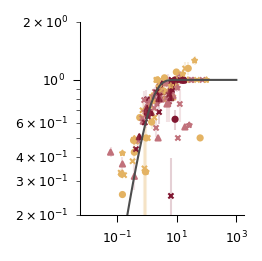

In [32]:

fitted_params = []
fig, ax = plt.subplots(1,1, figsize=(1.75,1.75), sharey=True, sharex=True)

marker_dict = {'PB':'o','LN':'^','SP':'*', 'BM':'x'}

singlet_prob_df['p_missing'] = 1-singlet_prob_df['mean']
for d_it, donor in enumerate(donors[:]):
    print(donor)
    n_tissues = len(set(donor_tissue_availability[donor]))
    donor_tissue_list = [t for t in tissue_list if f'{donor}_{t}' in donor_tissue_availability[donor]]
    for t_it, tissue in enumerate(tissue_list):
        i = t_it

        relevant_df = singlet_prob_df[(singlet_prob_df.discovery_tissue == tissue) 
                              & (singlet_prob_df.donor==donor)]
        if len(relevant_df) < 1:
            continue
        for at in relevant_df.ascertained_in.unique():
            tdf = relevant_df[relevant_df.ascertained_in == at]
            if tdf.shape[0]>0 and not (at == 'BM'):
 
                rez = curve_fit(f, tdf['n'], tdf['mean'])
                alpha = rez[0][0]
                fitted_params.append(pd.Series({'donor':donor,
                                                'ascertained':at,
                                                'discovered':tissue,
                                                'alpha':alpha}))

                # xs = np.logspace(-5,-2,50)
                # ax[i].plot(xs, 1-np.exp(-xs/alpha), color=tissue_colors[at])
                scaled_alpha = alpha
                ax.scatter(tdf['n']/scaled_alpha,
                        tdf['mean'],
                        color=tdf['ascertained_in'].map(tissue_colors),
                        s=6, 
                        clip_on=False,
                        marker=marker_dict[tissue])
                
                ax.errorbar(tdf['n']/scaled_alpha,
                        tdf['mean'],
                        tdf['std_err'],
                        alpha=0.2,
                        ecolor=tdf['ascertained_in'].map(tissue_colors),
                        fmt=' ',
                        clip_on=True)
            else:
                scaled_alpha=1
            # ax.set_title(f'Probability\nalso in {tissue}', weight='bold', color=tissue_colors[tissue])

            
ax.set_yscale('log')
ax.set_xscale('log')
xs = np.logspace(-2,3,50)
ax.set_ylim([0.2,2])
for tissue in ['PB','BM','SP','LN']:
    ax.plot([],[],lw=5, label=f'discovered in {tissue}', color=tissue_colors[tissue])
for tissue in ['PB','BM','SP','LN']:
    ax.scatter([],[], marker=marker_dict[tissue], color='k', label=f'also detected in {tissue}', s=8)
ax.plot(xs, 1-np.exp(-xs), color='0.3', zorder=100, label=r'$1 - e^{-x/x_c}$')

ax.set_xlabel(f'')
# ax.axhline(y=1, color='k', alpha=0.5, zorder=-1)
ax.set_ylabel('')

r,g,b,a = mpl.colors.to_rgba(tissue_colors[tissue])
bg_color = (r,g,b,0.5)

# ax[i].set_facecolor(bg_color)
sns.despine(fig)
# ax.set_ylabel('Scaled probability of\ndetection in second tissue')

# ax.legend(bbox_to_anchor=(1,1),loc='best', frameon=False, ncols=2, handlelength=0.7)
# ax.set_xlabel(f'Scaled lineage size in discovery tissue, $x/x_c$', fontsize=7, y=-0.1)
fig.tight_layout()

fitted_params = pd.DataFrame(fitted_params)
fig.savefig(f'{FIGURE_OUTDIR}/Figure2/collapse_all_donors.pdf', bbox_inches='tight')

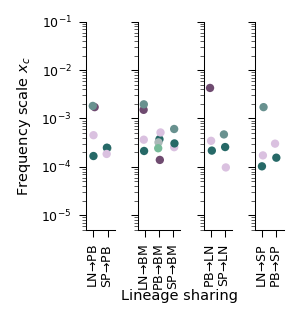

In [33]:
fig = plt.figure(figsize=(2.,2.25))
gs = fig.add_gridspec(1, 4, width_ratios=[2,3,2,2])
first_ax = fig.add_subplot(gs[0])
axes = [first_ax] + [fig.add_subplot(gs[i+1]) for i in range(3)]


fitted_params['tissue_pair'] =fitted_params['ascertained'] + r'$\to$' + fitted_params['discovered']
fitted_params = fitted_params.sort_values(by='tissue_pair')

fitted_params['n-hm'] = np.log10(fitted_params.alpha*5*10**9)/np.log10(2)
for i,at in enumerate(['PB','BM','LN','SP']):
    ax = axes[i]
    subset = fitted_params[fitted_params.discovered==at]

    g = sns.stripplot(subset, 
                      x='tissue_pair',
                      y='alpha', 
                      hue='donor',
                      palette=donor_colors,
                      ax=ax, 
                      size=4,
                      legend=False, 
                      clip_on=False)

    ax.set_yscale('log')
    # ax.set_ylim([10**-2,0.05])
    ax.set_xlabel('')
    ax.set_ylabel('')
    if i > 0:
        ax.set_yticklabels([])
    ax.set_ylim([5*10**-6, 10**-1])
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    old_xlim = ax.get_xlim()
for donor in donors:
    axes[-1].plot([],[],lw=6, color=donor_colors[donor], label=donor)
axes[-1].set_xlim(old_xlim)
axes[0].set_ylabel('Frequency scale $x_c$', fontsize=7)
sns.despine(fig)
fig.supxlabel('Lineage sharing', fontsize=7, x=0.6, y=0.1)
fig.tight_layout()
fig.savefig(f'{FIGURE_OUTDIR}/EDFigure3/collapse_parameter_downsample_to_{MIN_VDJS}.pdf', bbox_inches='tight')

### Plot lineage size distribution to see how many lineages are informing this

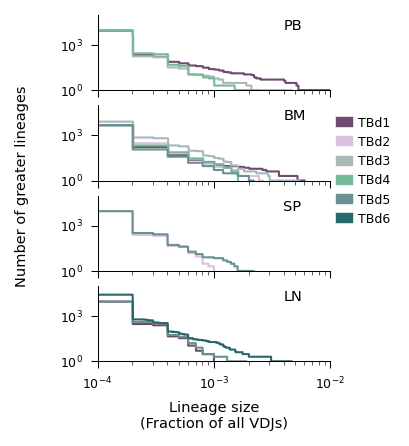

In [34]:
fig, axes = plt.subplots(4,1,figsize=(2,3), sharex=True)
for i, tissue in enumerate(tissue_list):
    ax = axes[i]
    tissue_subset = [x for x in cell_counts_all.columns
                     if tissue_dict.get(x,"") == tissue]
    tissue_dict
    for donor in donors:
        donor_subset = [x for x in tissue_subset if x.startswith(donor)]

        if len(donor_subset)>0:
            df_subset = cell_counts_all[donor_subset]
            df_subset = df_subset.mean(axis=1)
            g = sns.ecdfplot(df_subset,
                             stat='count',
                             ax = ax,
                             log_scale=(True, True),
                             complementary=True,
                             legend=False,
                             color=donor_colors[donor])
        ax.plot([],[], lw=5,
                       color = donor_colors[donor],
                       label=donor)
        ax.set_ylim([1,10**5])
    ax.text(0.8,0.8, tissue, color='k', transform=ax.transAxes, fontsize=7, weight='normal')
    xs = np.logspace(-5,-2,200)
    ax.set_xlim([10**-4,10**-2])
    ax.set_ylabel('')
    # ax.plot(xs, 0.0001/xs**2, color='k', alpha=0.5)
sns.despine(fig)
ax.set_xlabel('Lineage size\n(Fraction of all VDJs)', fontsize=7)

fig.supylabel('Number of greater lineages', fontsize=7, x=-0.15)
axes[1].legend(frameon=False, loc='upper left', handlelength=0.5, bbox_to_anchor=(1,1))
fig.savefig(f'{FIGURE_OUTDIR}/EDFigure3/lineage_size_distribution_downsampled.pdf', bbox_inches='tight')